In [1]:

# integrate luminosity functions out to M_UV = -10 equivalent maybe?
# convert from luminosity to sSFR with a better function than the one I have/ the one in Kennicutt & Evans 2012
# Then you have three points for Cosmic sSFR?

In [5]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
%matplotlib inline

Data = np.genfromtxt('schechterfits.csv', delimiter = ',')
red = Data[:,0]
rederr = Data[:,1]
mstar = Data[:,2]
mstarerr = Data[:,3]
alpha = Data[:,4]
alphaerr = Data[:,5]
pstar = Data[:,6]
pstarerr = Data[:,7]

In [51]:
mags = np.linspace(-10, -30, 1500)
lums = (10**(-.4*(mags + 48.6)))*(4*np.pi*3.086e19**2) # turning everything into ergs/s

lstar = 10**(-.4*(mstar + 48.6))*(4*np.pi*3.086e19**2) 
lstarerr = 10**(-.4*(mstar - mstarerr + 48.6))*(4*np.pi*3.086e19**2) - lstar

fits = []
errfit = []

for i in range(len(Data[:,0])):
    a = pstar[i]*(lums/lstar[i])**(alpha[i])*np.exp(-lums/lstar[i])
    b = (pstar[i]-pstarerr[i])*(lums/(lstar[i]+lstarerr[i]))**(alpha[i]+alphaerr[i])*np.exp(-lums/(lstar[i]+lstarerr[i]))
    fits.append(a)
    errfit.append(b)

fits = np.asarray(fits)
errfit = np.asarray(errfit)

Rsums = np.zeros([len(fits[:,0])])
Rsumserr = np.zeros([len(fits[:,0])])


for i in range(len(lums)):
    for j in range(len(fits[:,0])):
        if i < np.max(range(len(lums))):
            Rsums[j] += fits[j,i]*np.abs(lums[i]-lums[i+1]) # this is the luminosity density
            Rsumserr[j] += errfit[j,i]*np.abs(lums[i]-lums[i+1]) # this is something like the error

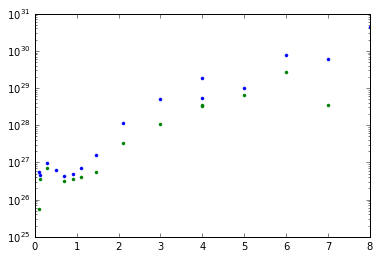

In [52]:
plt.semilogy(red, Rsums, '.')
plt.semilogy(red, Rsumserr, '.')


In [53]:
# from Kennicutt and Evans 2012

SFR = 10**(np.log10(Rsums) - 43.35)
SFRerr = 10**(np.log10(Rsumserr) - 43.35)


/home/max/anaconda2/envs/moresnakes/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10


/home/max/anaconda2/envs/moresnakes/lib/python3.5/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


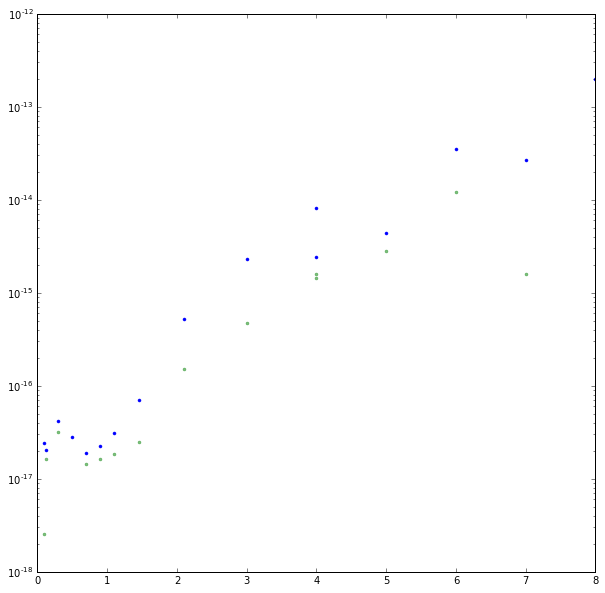

In [58]:
plt.figure(figsize=(10,10))
plt.semilogy(red, SFR, '.')
plt.semilogy(red, SFRerr, '.', alpha = .5)

# I couldn't get plt.errorbar to work (I never do for some reason) so the errors are printed in light green

I do not find a turn-off in the data like Madau does in Figure 9 with the Bouwens data, which is odd. I imagine they are using a more sophisticated conversion technique from UV to SFR than I am. I also might have the magnitude determination wrong, since my values are teensy weensy.

In [ ]:
def model(theta, z):
    sc = theta[0]*(1+z)**(theta[1])/(1+((1+z)/theta[2])**(theta[3]))
    return sc

def logL(theta, z, N, err):
    return -.5* np.sum((N - model(theta, z))**2./err**2.)

def lnprior(theta):
    
    # conditions go here
    else:
        return 0

def lnprob(theta, L, N, err):
    if lnprior(theta) == -np.inf:
        return -np.inf
    else:
        return logL(theta, L, N, err) + lnprior(theta)
    
ndim, nwalkers = 4, 100
pos = [[1e-4, -20, -1, -1]*np.random.randn(ndim) for i in range(nwalkers)]


sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = [reds, SFR, SFRerr])
sampler.run_mcmc(pos, 50000)    